In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from glob import glob
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import ResNet50, DenseNet121, InceptionV3, VGG16, MobileNet, Xception
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


## Create Paths

<font size='4'>[Link to Kaggle X-Ray Dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)</font>

In [4]:
#Cloud Path
path_to_train = '/home/ubuntu/project/chest_xray/train'
path_to_test = '/home/ubuntu/project/chest_xray/test'
path_to_val = '/home/ubuntu/project/chest_xray/val'

In [2]:
#Mac Path
path_to_train = '/Users/ferhat/Desktop/X_RAY/data/train'
path_to_test = '/Users/ferhat/Desktop/X_RAY/data/test/'
path_to_val = '/Users/ferhat/Desktop/X_RAY/data/val/'

In [2]:
#spot path
path_to_train = '/home/ubuntu/chest_xray/chest_xray/train'
path_to_test = '/home/ubuntu/chest_xray/chest_xray/test'
path_to_val = '/home/ubuntu/chest_xray/chest_xray/val'

## Image Preprocessing

Text(0.5, 1.0, 'Pneumonia')

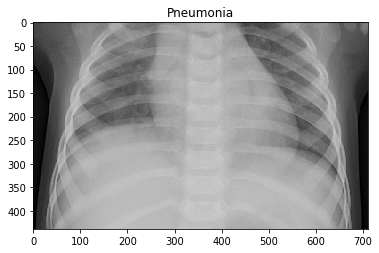

In [3]:
plt.imshow(mpimg.imread(path_to_train + '/PNEUMONIA/person1_bacteria_1.jpeg'))
plt.title('Pneumonia')

Text(0.5, 1.0, 'Normal')

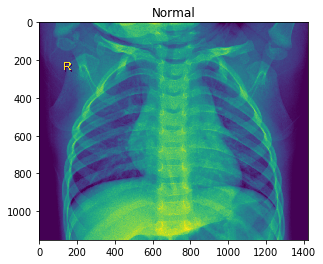

In [4]:
plt.imshow(mpimg.imread(path_to_train + '/NORMAL/IM-0117-0001.jpeg'))
plt.title('Normal')

## CNN Architecture

- Some of the layers within CNN's:  Convolutional Layer, Pooling Layer, Activation Layer, and Fully-Connected Layer
<br><br>   
- **Convolutional Layer** - Image becomes stack of filtered images (depending on how many filters you choose to use)
   Parameters:
   - Number of filters
   - Size of filters

<img src="img/picture.png" width="400">


- **Pooling Layer** - Downsample the stack of filtered images<BR>
    Parameters:
    - Window size
    - Window stride

<img src="img/picture2.png" width="500">

- **Nonlinearity function**
    - ReLu Activation Layer - Steps through values in images and converts negative numbers to zero 
    - Softmax
    - Logit

<img src="img/relu.png" width="400">

- **Fully Connected Layer** - Where each neuron will be connected to all neurons in next layer

<img src="img/fully.png" width="350">

## Data Augmentation

In [14]:
ImageDataGenerator?

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(
        rescale=1./255)

valid_datagen = ImageDataGenerator(
        rescale=1./255) 


In [3]:
batch_size = 32
image_size = 128
    
train_generator = train_datagen.flow_from_directory(
        path_to_train,
        target_size=(image_size,image_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        path_to_test,
        target_size=(image_size,image_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')


validation_generator = valid_datagen.flow_from_directory(
        path_to_val,
        target_size=(image_size,image_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

print("Shape of training images {}".format(train_generator.image_shape))
print("Shape of test images {}".format(test_generator.image_shape))
print("Shape of validation images {}".format(validation_generator.image_shape))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Shape of training images (128, 128, 1)
Shape of test images (128, 128, 1)
Shape of validation images (128, 128, 1)


## Create model

In [4]:
def create_model():
    global model
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding="same",
                 input_shape=(image_size,image_size,1)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(1024,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.4))
    model.add(Dense(2, activation="softmax"))

In [5]:
create_model()

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
__________

##  Callbacks

In [ ]:
EarlyStopping?

In [37]:
ReduceLROnPlateau?

In [7]:
optimizer = 'adam'
epoch = 20
loss = 'mse'

NAME = 'X_ray_classifier-{}-{}-{}'.format(optimizer,epoch,loss)

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

es = EarlyStopping(patience=5)

checkpoint = ModelCheckpoint('best_model.h5',save_best_only=False)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max') 

## Backend

## Train Model

In [8]:
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])
history = model.fit_generator(
          train_generator,
          epochs=epoch,
          steps_per_epoch=train_generator.samples / batch_size,
          validation_data=test_generator,
          validation_steps=test_generator.samples / batch_size,
          callbacks=[es, tensorboard, checkpoint])

Epoch 1/20
163/163 [==============================] - 75s 463ms/step - loss: 0.1123 - acc: 0.8635 - val_loss: 0.3750 - val_acc: 0.6250
Epoch 2/20
163/163 [==============================] - 71s 437ms/step - loss: 0.0736 - acc: 0.9095 - val_loss: 0.3750 - val_acc: 0.6250
Epoch 3/20
163/163 [==============================] - 72s 441ms/step - loss: 0.0693 - acc: 0.9176 - val_loss: 0.3480 - val_acc: 0.6298
Epoch 4/20
163/163 [==============================] - 71s 437ms/step - loss: 0.0602 - acc: 0.9287 - val_loss: 0.3750 - val_acc: 0.6250
Epoch 5/20
163/163 [==============================] - 71s 435ms/step - loss: 0.0713 - acc: 0.9151 - val_loss: 0.1003 - val_acc: 0.8782
Epoch 6/20
163/163 [==============================] - 71s 433ms/step - loss: 0.0656 - acc: 0.9208 - val_loss: 0.3749 - val_acc: 0.6250
Epoch 7/20
163/163 [==============================] - 73s 445ms/step - loss: 0.0578 - acc: 0.9308 - val_loss: 0.2787 - val_acc: 0.7051
Epoch 8/20
163/163 [==============================] - 7

## Evaluate

In [14]:
model.metrics_names

['loss', 'acc']

In [15]:
model.evaluate_generator(validation_generator,steps=16)

[0.3424018621444702, 0.625]

In [16]:
def create_plots(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy-{}'.format(NAME))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss-{}'.format(NAME))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Next steps....

## - Optimization techniques

<font size='4'>
 - Manual Tuning <br>
 - GridSearch <br>
 - RandomSearch <br>
 - Bayesian Optimization <br>
</font>

## - Deploying to Production via Flask/RESTful API

## Awesome free resources
- [Deep Learning AI](https://www.deeplearning.ai/)
- [Nathaniel Tucker](https://github.com/knathanieltucker/a-bit-of-deep-learning-and-keras)
- [Fast AI](https://www.fast.ai/)